In [1]:
#import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import pandas as pd

In [2]:
#parameters

In [3]:
Dim      = 177             # system size in grid points, +2 for the boundary conditions
tOut     = 100           #output interval in time steps
nSteps   = 200000          #number of time steps

dx       = 0.25*1e-3       # space descretization , m
dt       = 1*1e-3          # time descretization, s


#Process parametrs from literature
Rho      = 7440            #density in kg/m3
Cp       = 720             #Specific heat in J/kg/K
Lambda   = 30              # heat conductivity in W/m*K
RhoCp    = Rho*Cp          # Heat capacity, J/cm^3*K, 6990*830 J/m^3*K
L        = 2.71*1e5*Rho    # latent heat, J/m^3

#from previous simulation(ANSYS) data and process data
h_Mould  = 2000            # Average Heat transfer coefficient in the mould, W/(m^2).K
h_sc     = 0.5*h_Mould     # Average Heat transfer coefficient in the secondary cooling region, W/(m^2).K
h_rad    = 0.35*h_Mould    # Average Heat transfer coefficient in the radiation region, W/(m^2).K
Tambi    = 300.0           # Temperature of the mould, K
T0       = 1813.0          # pouring/initial temperature of the liquid metal, K
C_0     = 0.18

#From JMatPrp
Tpure    = 1809            # melting point of pure iron (1536 8C)
Tliq     = 1787.0          # Liquidus temperature, K
Tsol     = 1747.0          # Solidus temperature, K
Tpure    = 1809            # melting point of pure iron (1536 8C)
#From linear phase diagram
m_liq   = (Tliq-Tpure)/C_0
m_sol   = (Tsol-Tpure)/C_0
k       = m_liq/m_sol

#time for the slice to pass mould , secondary cooling and radiation
Lmould  = 1.10             # Length of mould in m
Lsc     = 9.00             # Length of seconadry cooling in m
Vcast   = 0.0833           #m/s (5m/min)
t_mould = Lmould/Vcast
t_sc    = Lsc/Vcast

T_V      = Tsol            #Temperature at which the velocity is calculated

#checking the modul
modul = (Lambda/RhoCp)*dt/dx**2
print (modul<0.5)

True


In [4]:
#Temperature calculation

In [5]:
Tx   = [T0 for x in range(Dim)]                #Nodal temperatures at time step, t
Tx_p = [T0 for x in range(Dim)]                #Nodal temperatures at time step, t-dt
t_Temp = 100
Tdata = np.zeros([int(nSteps/t_Temp +1), Dim])
Ttime = np.zeros(int(nSteps/t_Temp +1))
time = 0
for tStep in range(nSteps+1): 
#for tStep in range(5000):
    time += dt
    #Boundary conditions based on slab location in the process with respect to time
    if time<= t_mould:                                #while the slab is inside the mould
        qdot = h_Mould*(Tx[1]-Tambi)
    elif time>t_mould and time<=t_sc :                #while the slab is in the secondary cooling zone
        qdot = h_sc*(Tx[1]-Tambi)
    else:
        qdot = h_rad*(Tx[1]-Tambi)                    #while the slab is in the radiation zone
        
                      
    Tx[Dim-1] = Tx[Dim-2]                             # right hand boundary condition, adiabatic heat transfer
    Tx[0] = Tx[1] - qdot*dx/Lambda                    # left hand boundary condition, based on the available cooling
    
    #spatial loop
    for x in range(1, Dim-1): 
        mass = RhoCp
        if Tx[x]> Tsol and Tx[x]< Tliq :                # relaese of Latent heat in the window of solidification
            mass += L/(Tliq - Tsol)
    
        dTx = Lambda*dt*(Tx[x-1] - 2.0*Tx[x] + \
                         Tx[x+1])/(dx*dx)/mass          #Forward euler approximation
        
        Tx[x] += dTx                                    #Temperature of node x at time tStep
    if (tStep%tOut)==0 :
        t = int(tStep/tOut)
        Tdata[t,:] = Tx
        Ttime[t]    = t*t_Temp*dt

df = pd.DataFrame(index=Ttime, data=Tdata)
df.to_csv('Temp_time.csv',sep=',', header=None )

In [6]:
data = pd.read_csv('Temp_time.csv',sep=',', header=None )

In [7]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
0,0.0,1787.783333,1810.740442,1812.797531,1812.981858,1812.998374,1812.999854,1812.999987,1812.999999,1813.000000,...,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0
1,0.1,1751.342204,1775.819336,1786.341287,1792.354641,1797.651826,1802.036286,1805.462188,1808.005087,1809.806881,...,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0
2,0.2,1741.467558,1765.811717,1780.099531,1786.736053,1791.162584,1795.231393,1798.831361,1801.914919,1804.486067,...,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0
3,0.3,1733.719288,1757.948337,1773.980661,1783.264586,1787.517743,1791.355167,1794.795026,1797.851535,1800.538321,...,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0
4,0.4,1727.193563,1751.321343,1768.323438,1779.147958,1785.458498,1788.856892,1792.004657,1794.900408,1797.540008,...,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0


In [8]:
time_list = data[0].values

In [9]:
Tdata = data.T[1:]

In [19]:
#function to get the position of the liquidus

In [12]:
X_liq =0
def get_X_liq(Tx):
    global X_liq
    for x in range(1, Dim-1): 
        if  Tx[x] > Tliq and Tx[x-1]<=Tliq:

            ml = (Tx[x] -Tx[x-1])/dx       #slope of the line
            X_liq = x*dx -(Tx[x]-Tliq)/ml   #linear interpolation, liquidus point at tStep
            break

In [13]:
#function to get the position of the solidus

In [14]:
X_sol =0
def get_X_sol(Tx):
    global X_sol
    for x in range(1, Dim-1): 
        if  Tx[x] > Tsol and Tx[x-1]<=Tsol:

            ms = (Tx[x] -Tx[x-1])/dx       #slope of the line
            X_sol = x*dx -(Tx[x]-Tsol)/ms   #linear interpolation, liquidus point at tStep
            break

In [15]:
#Function to write the output

In [20]:
Tout = np.zeros([Dim,int(nSteps/(tOut*tOut) +1)])      #Output temperatures at every tOut time steps
Tout[:,0] = Tdata[0].values
fs_out = np.zeros(int(nSteps/(tOut*tOut) +1))          #output fs at every tOut time steps
dfs_out = np.zeros([Dim-2,int(nSteps/(tOut*tOut) +1)]) 
Cs_out = np.zeros([Dim-2,int(nSteps/(tOut*tOut) +1)])   
Cl_out = np.zeros([Dim-2,int(nSteps/(tOut*tOut) +1)])
Xsol_out = []
Xliq_out = []
time_p = 0
V_sol = []                                      #solidification velocity at solidus point
V_liq = []                                      #solidification velocity at liquidus point
X_sol_p = 0
X_liq_p = 0
def get_op(tStep, Tx):
    global time, time_p, X_sol_p, X_liq_p
    t = int(tStep/tOut)
    t_in_sec = tStep*tOut*dt
    Tout[:,t] = Tx
    fs_out[t] = fs[tStep]
    dfs_out[:,t] = dfs
    Cs_out[:,t] = Cs_f
    Cl_out[:,t] = Cl_f
    if (X_liq-X_liq_p)>0:
        V_liq.append((X_liq-X_liq_p)/(time-time_p))
        Xliq_out.append(X_liq*1000)    #X_liq in mm
    if (X_sol-X_sol_p)>0:        
        V_sol.append((X_sol-X_sol_p)/(time-time_p))
        Xsol_out.append(X_sol*1000)    #X_sol in mm
    time_p =t_in_sec
    X_sol_p = X_sol
    X_liq_p = X_liq

In [21]:
#Main loop that calculates solid fractions and concentrations

In [22]:
import time
time_start = time.time()
#Intiation of parameters

dfs  = np.zeros(Dim-2)                      #Array of Nodal solid fractions at time step, t
dfs_p  = [0  for x in range(Dim-2)]         #Nodal solid fraction at each time step, t-dt
fs   = np.zeros(nSteps +1)                  #total fraction of solid at time step, t

Cl_f = [C_0 for x in range(Dim-2)]          #Array of liquidus concentrations of the solidifying front at time t
Cl_p  = [C_0  for x in range(Dim-2)]        #Array of liquidus concentrations of the solidifying front at time t-dt
Cs_f = [0 for x in range(Dim-2)]        #Array of solidus concentrations of the solidifying front at time t

for tStep in range(len(time_list)): 
    time = tStep*tOut*dt
    Tx = Tdata[tStep].values                                    
    get_X_liq(Tx)                           # To get the position of liquidus temperature  at each time step
    get_X_sol(Tx)                           # To get the position of solidus temperature at each time step

#To get dfs, fs and interface concentrations
    fs_t = 0
    dC_0 = 0
    
    for x in range(1, Dim-1):        
        if  Tx[x] <= Tliq and Tx[x] >=Tsol:    
            dfs[x-1]     =  (Tliq-Tx[x])/(Tliq-Tsol)
            
            Cl_f[x-1]    =  C_0*(1/(1-dfs[x-1]*(1-k))) #lever rule with C_0
            Cs_f[x-1]    =   k*Cl_f[x-1] 

            #Solute rejection into liquid at the solidification front

            Dfs = dfs[x-1]-dfs_p[x-1]
        
        if  Tx[x] <= Tsol:    
            dfs[x-1]    =  1
        
        fs_t += dfs[x-1]
        dfs_p[x-1]  = dfs[x-1]
    
    fs[tStep] =  fs_t/(Dim-2)
    
    #Writing Tout, fs_out, dfs_out, Cs_out, Cl_out, Cliq_out
    if (tStep%tOut)==0 :
        get_op(tStep, Tx)

np.savetxt('Tx.dat', Tout)
import time
time_finish = time.time()
print (time_finish-time_start)

/home/users/uddagm6h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/users/uddagm6h/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


0.6269698143005371


In [23]:
Tdata_1 = np.loadtxt('Tx.dat')

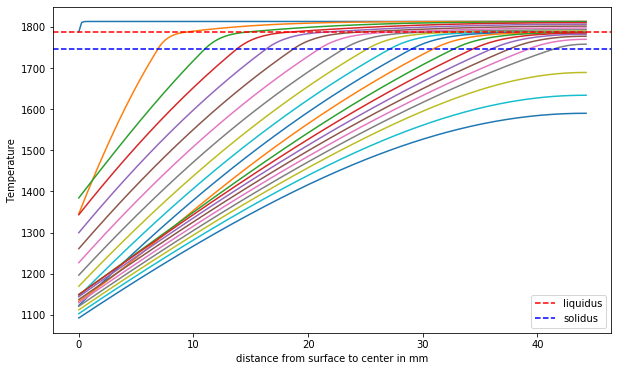

In [24]:
for i in range(len(Tdata_1[0])):
    plt.plot(np.linspace(0,Dim*dx*1000, Dim), Tdata_1[:,i])
plt.axhline(y=Tliq,color='r', ls = 'dashed' , label = "liquidus")
plt.axhline(y=Tsol, color='b', ls = 'dashed', label ='solidus')

plt.ylabel('Temperature')
plt.xlabel('distance from surface to center in mm')
fig = plt.gcf()
fig.set_size_inches(10,6)

#plt.xlim(0,10)
#plt.ylim(Tsol-500, Tsol+40)
plt.legend()
fig.savefig('1D_Heat', dpi=100)

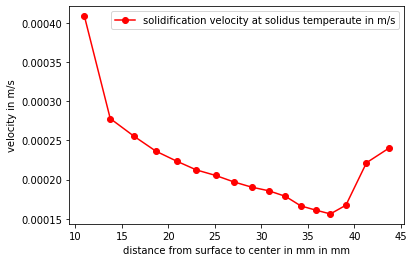

In [25]:
plt.plot(Xsol_out, V_sol, 'r-o', label = 'solidification velocity at solidus temperaute in m/s')
plt.xlabel('distance from surface to center in mm in mm')
plt.ylabel('velocity in m/s')
plt.legend()
plt.savefig('Velocity_sol')

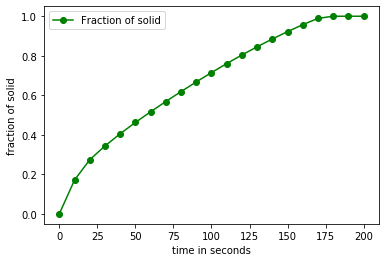

In [26]:
plt.plot(np.linspace(0,nSteps*dt,21), fs_out, 'g-o', label = 'Fraction of solid')
plt.ylabel('fraction of solid')
plt.xlabel('time in seconds')
plt.legend()
plt.savefig('fs')

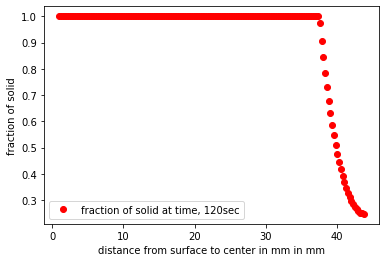

In [27]:
plt.plot(np.linspace(1,(Dim-2)*dx*1000, Dim-2),dfs_out[:,15], "ro", label ='fraction of solid at time, 120sec')
plt.xlabel('distance from surface to center in mm in mm')
plt.ylabel('fraction of solid')
plt.legend()

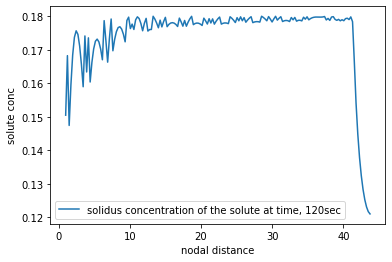

In [28]:
plt.plot(np.linspace(1,(Dim-2)*dx*1000, Dim-2),Cs_out[:,17],label ='solidus concentration of the solute \
at time, 120sec' )
plt.xlabel('nodal distance')
plt.ylabel('solute conc')
plt.legend()

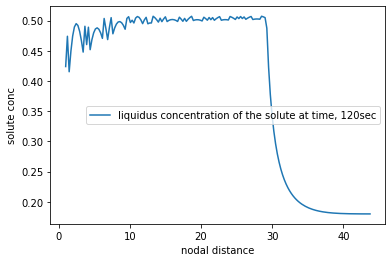

In [29]:
plt.plot(np.linspace(1,(Dim-2)*dx*1000, Dim-2),Cl_out[:,10],label ='liquidus concentration of the solute \
at time, 120sec' )
plt.xlabel('nodal distance')
plt.ylabel('solute conc')
plt.legend()

In [38]:
#Solving curvature radius peclet number 
#from the condition of microscopic solvability(marginal stability)